<a href="https://colab.research.google.com/github/ivanrnarvaez/text_mining/blob/main/3_TextRepresentation_tecnicasEmbedding_master_alumnos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports y funciones auxiliares

In [ ]:
!pip install numpy==2.0.0
!pip install gensim

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Huggingface imports
from transformers import AutoModel, AutoTokenizer
# GPU imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Imports
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

# NLP
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords

In [ ]:
def tsne_dim_reduction(dataframe, vector_column, seed):
    """
    Perform t-SNE dimensionality reduction on the specified vector column in the DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame containing the data.
    - vector_column (str): The name of the column in the DataFrame containing the vector embeddings.
    - seed (int): Random seed for reproducibility.

    Returns:
    pd.DataFrame: A new DataFrame containing t-SNE reduced 2-dimensional vectors, along with
                  'section_label' and 'segment' columns from the input DataFrame.
    """
    dataframe = dataframe.reset_index(drop=True)
    X = np.array(dataframe[vector_column].tolist())
    X_tsne = TSNE(n_components=2, random_state=seed).fit_transform(X)

    # Agregar los resultados a un nuevo DataFrame
    df_tsne = pd.DataFrame(data=X_tsne, columns=['x', 'y'])
    df_tsne['content'] = dataframe['content']
    df_tsne['target']  = dataframe['target']
    df_tsne['target_names']  = dataframe['target_names']
    return df_tsne

In [ ]:

def plotly_2_scatters(dftsne1, dftsne2, label_column, text_column, text_column2, width=1400, height=400):
    """
    Create a combined interactive plot with two scatter plots side by side using Plotly. The aim is to visualize
    embeddings in 2D representation.

    Parameters:
    - dftsne1 (pd.DataFrame): The first DataFrame containing t-SNE reduced data for the first scatter plot.
    - dftsne2 (pd.DataFrame): The second DataFrame containing t-SNE reduced data for the second scatter plot.
    - label_column (str): The column name in the DataFrames to determine the color of the points.
    - text_column (str): The column name in the DataFrames to use for hover text.
    - width (int): Width of the combined plot.
    - height (int): Height of the combined plot.
    """

    # Create left-side scatter
    fig = px.scatter(
        dftsne1, x='x', y='y',
        color=label_column, labels={'color': label_column},
    hover_data=[text_column])

    # Generate a subplot containing 1 row and two columns.
    fig_subplots = make_subplots(rows=1, cols=2)

    # Add each scatter series to the first subplot.
    for trace in fig.data:
        fig_subplots.add_trace(trace, row=1, col=1)

    # Create right-side scatter
    fig_2 = px.scatter(
        dftsne2, x='x', y='y',
        color=label_column, labels={'color': label_column},
    hover_data=[text_column])

    #Add data to the second subplot
    for trace in fig_2.data:
        fig_subplots.add_trace(trace, row=1, col=2)



    # Update layouts to show legend.
    fig_subplots.update_layout(showlegend=True, width=width, height=height)

    # show figure
    fig_subplots.show()


# Representación numérica de textos
En la mayoría de técnicas comúnmente utilizadas en Text Mining y NLP es necesario representar los textos en forma de vectores numéricos para que puedan ser procesados por modelos estadísticos o modelos de aprendizaje automático. Existen diferentes formas de representar el texto de esta manera, todas de ellas consisten en mapear la información a un espacio vectorial, numérico, aunque difieren en la manera de modelar los datos. En el notebook anterior, se ha llevado a cabo una representación vectorial a nivel de documento utilizando técnicas léxicas, en este notebook trabajaremos el concepto de embeddings.


Los embeddings son una técnica de modelización de lenguaje que permite representar palabras mediante vectores densos (*dense vectors*), de menor tamaño que los obtenidos con técnicas de tipo *bag of words*, y que además tienen capacidad de representar información semántico.

Según su modo de entrenamiento, se distinguen dos grandes tipos: los embeddings estáticos, como Word2Vec o GloVe, que asignan un único vector a cada palabra sin considerar el contexto; y los embeddings contextuales, como BERT o RoBERTa, que generan representaciones diferentes según el entorno lingüístico en el que se encuentra cada palabra.

Mientras que los embeddings estáticos son muy eficientes y fáciles de utilizar, presentan limitaciones al manejar palabras polisémicas. En cambio, los embeddings contextuales logran captar de forma más precisa el significado dinámico de las palabras dentro de una oración, mejorando notablemente el rendimiento en tareas de procesamiento de lenguaje natural.






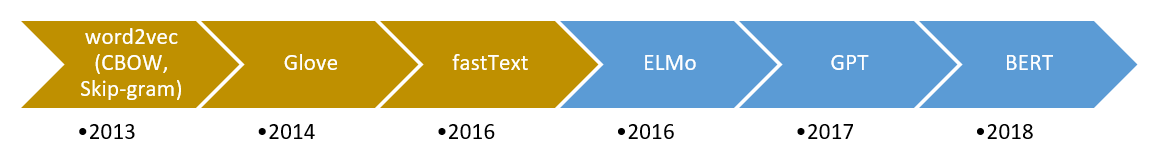

En este notebook aprenderemos a utilizar embeddings estáticos pre-entrenados utilizando la librería [gensim](https://radimrehurek.com/gensim/models/word2vec.html). Los embeddings estáticos permiten obtener representaciones vectoriales de palabras individualmente, así que en el notebook también aprenderemos a representar documentos utilizando este tipo de representación. Como recurso extra se mostrará un código de entrenamiento de estos embeddings para aquellos que tengan interés en el proceso de entrenamiento.

En el ejercicio también veremos como obtener embeddings contextuales utilizando la librería  [Transformers](https://huggingface.co/docs/transformers/index)

## Carga de datos



En este notebook vamos a trabajar con un subconjunto de datos del corpus [20 newsgroup](http://qwone.com/~jason/20Newsgroups/), que contiene originalmente 20000 documentos clasificados en 20 categorías según su contenido.

Comenzamos leyendo el dataset directamente desde un repositorio de github:

In [ ]:
dataset =pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

Vamos a visualizar las 20 categorías del conjunto de datos. Observamos que hay contenido sobre ciencia, religión (con subcategorías), política...

In [ ]:
dataset.target_names.value_counts()   # value_counts()

Para el ejercicio nos quedaremos con dos subsets de datos diferentes. Uno que contenga dos categorías muy diferentes (como religión y medicina) y otro que contenga categorías muy parecidas (como subcategorías de política).

In [ ]:
subset_diferente = dataset[dataset.target_names.isin(['talk.religion.misc', 'sci.med'])].reset_index(drop=True).copy()
subset_parecido = dataset[dataset.target_names.isin(['talk.politics.mideast', 'talk.politics.guns', 'talk.politics.misc'])].reset_index(drop=True).copy()
#'talk.politics.mideast', 'talk.politics.guns', 'talk.politics.misc'

Se observa que el contenido de las noticias requiere de cierto preprocesado. Vamos a aplicar un preprocesado sencillo para eliminar URLs, eliminar caracteres especiales y pasar a minúculas

In [ ]:
subset_parecido.content.iloc[0]

In [ ]:
from nltk.corpus import stopwords

def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)

    # remove stopwords
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    text = " ".join(tokens)
    text = text.lower().strip()

    return text

In [ ]:

subset_diferente['text_cleaned'] = subset_diferente['content'].apply(lambda text: preprocess_text(text))
subset_parecido['text_cleaned'] = subset_parecido['content'].apply(lambda text: preprocess_text(text))

De esta manera ya tenemos los datos preparados para trabajar con ellos

## Embeddings


### Embeddings estáticos

Los embeddings estáticos son una técnica básica en el procesamiento del lenguaje natural (NLP) que se utiliza para representar palabras o frases en un espacio vectorial. La idea detrás de estos embeddings es convertir palabras (cadenas de caracteres) a vectores numéricos densos, de menor tamaño que los vectores de las técnicas de Bag Of Words, y que contienen información sobre su semántica.

Una vez generados, estos vectores presentan propiedades interesantes: por ejemplo, palabras con significados similares tienden a estar próximas en el espacio vectorial, y ciertas relaciones semánticas pueden representarse mediante operaciones algebraicas (como "Rey - Hombre + Mujer ≈ Reina").









![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SYiW1MUZul1NvL1kc1RxwQ.png)

#### Carga de embeddings pre-entrenados con ``gensim``






Los embeddings suelen ser entrenados con grandes conjuntos de datos y suele ser costoso su entrenamiento a nivel temporal. Por ese motivo, una de las posibilidades cuando se trabaja con embeddings, es la búsqueda de recursos ya entrenados con textos similares a los que vayamos a trabajar (como contenido de noticias o redes sociales), y utilizarlo para representar nuestros documentos.


Cuando se busca este tipo de recurso es evidente la influencia anglosajona en el desarrollo de las tecnologías del lenguaje, ya que la mayoría de los recursos se encuentran en este idioma y son fácilmente aplicables desde las librerías de NLP más comunes, en este caso Gensim. Si se quieren utilizar recursos en otros idiomas, hay que buscarlos en repositorios externos para descargarlos manualmente y cargarlos en la librería en cuestión.

En esta sección vamos a aprender a cargar embeddings pre-entrenados utilizando gensim, así como cargar embeddings entrenados que se pueden descargar de diversas fuentes de internet.


##### Carga de pre-trained embeddings de gensim


La librería Gensim cuenta con un conjunto de embeddings pre-entrenados accesibles desde la propia librería mediante una API.

Para acceder a estos modelos basta con utilizar el comando ```gensim.downloader.info()```, que nos permitirá ver la lista de modelos disponibles:

In [ ]:
!pip install gensim

In [ ]:
import gensim.downloader as api
print("Este es el listado de modelos disponibles en Gensim: \n {}".format(list(api.info()["models"].keys())))


Se puede observar que no sólo hay embeddings word2vec. También los hay glove, fasttext y conceptnet, todos estáticos. En este caso vamos a cargar un embedding Glove por ocupar menos espacio en memoria.

In [ ]:
glove_emb = api.load('glove-twitter-25') #'glove-twitter-25'

Una vez hayamos cargado el embedding, podemos aplicar diferentes funciones de gensim para obtener información útil:

- Listado de palabras más similares a una dada


In [ ]:
glove_emb.most_similar('noise') # noise - palabras más similares se consiguen con most_similar y topn

-  Operación matemática con vectores para obtener resultados

In [ ]:
glove_emb.most_similar(positive=["france","italy"],negative=["rome"])

-  Detectar término "intruso"

In [ ]:
glove_emb.doesnt_match(['spain', 'italy', 'paris'])

-  Obtener el vector que representa a una palabra para utilizarlo posteriormente en otras tareas

In [ ]:
glove_emb.get_vector('noise') # con get_vector(token)

##### Vector de documento utilizando embedding estáticos

Como se observa, los embedding estáticos permiten obtener representaciones vectoriales de palabras individualmente. Si queremos obtener la representación de un documento se debería calcular un vector del documento como la media de los vectores de las palabras que lo componen.

Supongamos que tenemos un documento *D*  compuesto por *N* palabras, donde cada palabra $w_i$ tiene un vector de embedding estático asociado, denotado como $\vec{v}_i$.

Para obtener la representación vectorial de $D$, se debería aplicar la siguiente fórumla:

$$ \vec{V}_D = \frac{1}{N} \sum_{i=1}^{N} \vec{v}_i $$

Donde:
- $\vec{V}_D$ es el vector representativo del documento.
- $N$ es el número total de palabras en el documento.
- $\vec{v}_i$ es el vector de embedding de la palabra $i$-ésima.
- $\sum$ denota la suma vectorial.

Este tipo de embedding permite obtener representaciones vectoriales de paalabras individuales. Si queremos obtener representaciones de documentos deberíamos constuir un vector calculado como la media de los vectores de las palabras que lo componen:

In [ ]:
def embedding_doc(tokens, gensim_emb, n):
  """
  Función que calcula el vector medio de una lista de
  tokens
  """
  lista = list()
  for i in tokens:
    try:
      lista.append(gensim_emb.get_vector(i) )
    except:
      continue

  try:
    resultado = np.mean(lista, axis=0)
  except:
    resultado = np.zeros(n)
  return resultado

De este modo, introduciendo una lista de tokens de un documento y un embedding, se obtendría el vector medio:


In [ ]:
embedding_doc(["El","gato","se","tumba","en","su","cama"], glove_emb, glove_emb.vector_size)

##### Carga de pre-trained embedding de otras fuentes


Como hemos visto anteriormente, no siempre se encuentran embeddings en el idioma en el que estamos trabajando. Si se quiere trabajar en un idioma diferente al inglés es necesario trabajar con un embedding entrenado con textos en español.

En este apartado vamos a cargar un [Word2Vec embedding en español](https://github.com/aitoralmeida/spanish_word2vec)l creado con datos de noticias, Wilipedia y el BOE entre otros y no disponible de forma nativa en la librería de Gensim.


En primer lugar descargamos y hacemos unzip del modelo:

In [ ]:
!wget https://zenodo.org/record/7884437/files/complete.bin.zip?download=1
!unzip /content/complete.bin.zip?download=1

Una vez descargado y descomprimido, cargamos los ``KeyedVectors``, una manera de almacenar un embedding de forma eficiente y que permite ahorrar espacio de almacenamiento y memoria.


In [ ]:
from gensim.models import KeyedVectors

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('complete.bin', binary=True)

Una vez cargado, podemos aplicar las funciones del embedding disponibles en Gensim, además de obtener la representación vectorial de cada palabra.

In [ ]:
word_vectors.most_similar(positive=["españa","italia"],negative=["roma"])

In [ ]:
word_vectors.similar_by_word("ruido")

In [ ]:
word_vectors.get_vector("hola")

### Embeddings contextuales

Los embeddings contextuales son una técnica más avanzada de representación de palabras y documentos en el espacio vectorial. Este tipo de representación se construye sobre el mecanismo de atención y la arquitectura transformers, y permite obtener representaciones vectoriales de términos que cambian según los términos que les siguen y preceden.

Este tipo de representación contextual se obtiene utilizando los *modelos de lenguaje*, obtenidos tras el entrenamiento de la arquitectura neuronal Transformers utilizando millones de documentos. Estos modelos de lenguaje permiten obtener representaciones vectoriales de textos con una alta calidad, generadas tras el aprendizaje de patrones complejos de uso del lenguaje. A diferencia de las representaciones vectoriales estáticas como Word2Vec o GloVe, los embeddings contextuales capturan el significado de una palabra en contextos específicos, permitiendo una comprensión más matizada del lenguaje.


Los modelos de lenguaje son entrenados y publicados por organismos con grandes capacidades de cálculo como centros de investigación, universidades o empresas tecnológicas; para que puedan ser reutilizados por la comunidad cientifico-tecnológica para múltiples propósitos. El uso de estos modelos, así como su adaptación, es relativamente sencillo gracias a librarías como [Transformers](https://huggingface.co/docs/transformers/index)

Los modelos publicados se suelen componer de un tokenizador específico del modelo de lenguaje, que es el encargado de subdividir nuestros textos en tokens; y el modelo de lenguaje en si mismo, que es la arquitectura neuronal entrenada previametne.

#### Obtención de representación vectorial contextual utilizando modelos de lenguaje

Para utilizar un modelo de lenguaje y obtener las representaciones vectoriales utilizaremos dos de las clases principales de huggingface:  `AutoTokenizer` y `AutoModel`. Estas dos clases permiten descargar, cargar y utilizar modelos de lenguaje publicados en el [hub de modelos de HuggingFace](https://huggingface.co/models). Estas clases permiten cargar un modelo de lenguaje independientemente del framework de *deep learning* con el que haya sido entrenado (Torch, Transformers,...), y utilizarlo en tu sistema.

En este caso utilizaremos el modelo [bert-base-uncased](https://huggingface.co/bert-base-uncased), que nos permitirá trabajar con documentos en inglés

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained('bert-base-uncased')

La idea de la obtención del embedding se muestra en la [figura](https://tinkerd.net/blog/machine-learning/bert-embeddings/) en la que la frase será tokenizada e introducida al modelo.

Durante la tokenización, se añade el token especial `[CLS]` al inicio de la secuencia, el cual está diseñado para representar el contenido del texto al completo, aunque también podríamos obtener la media de los embeddings de cada uno de los tokens.









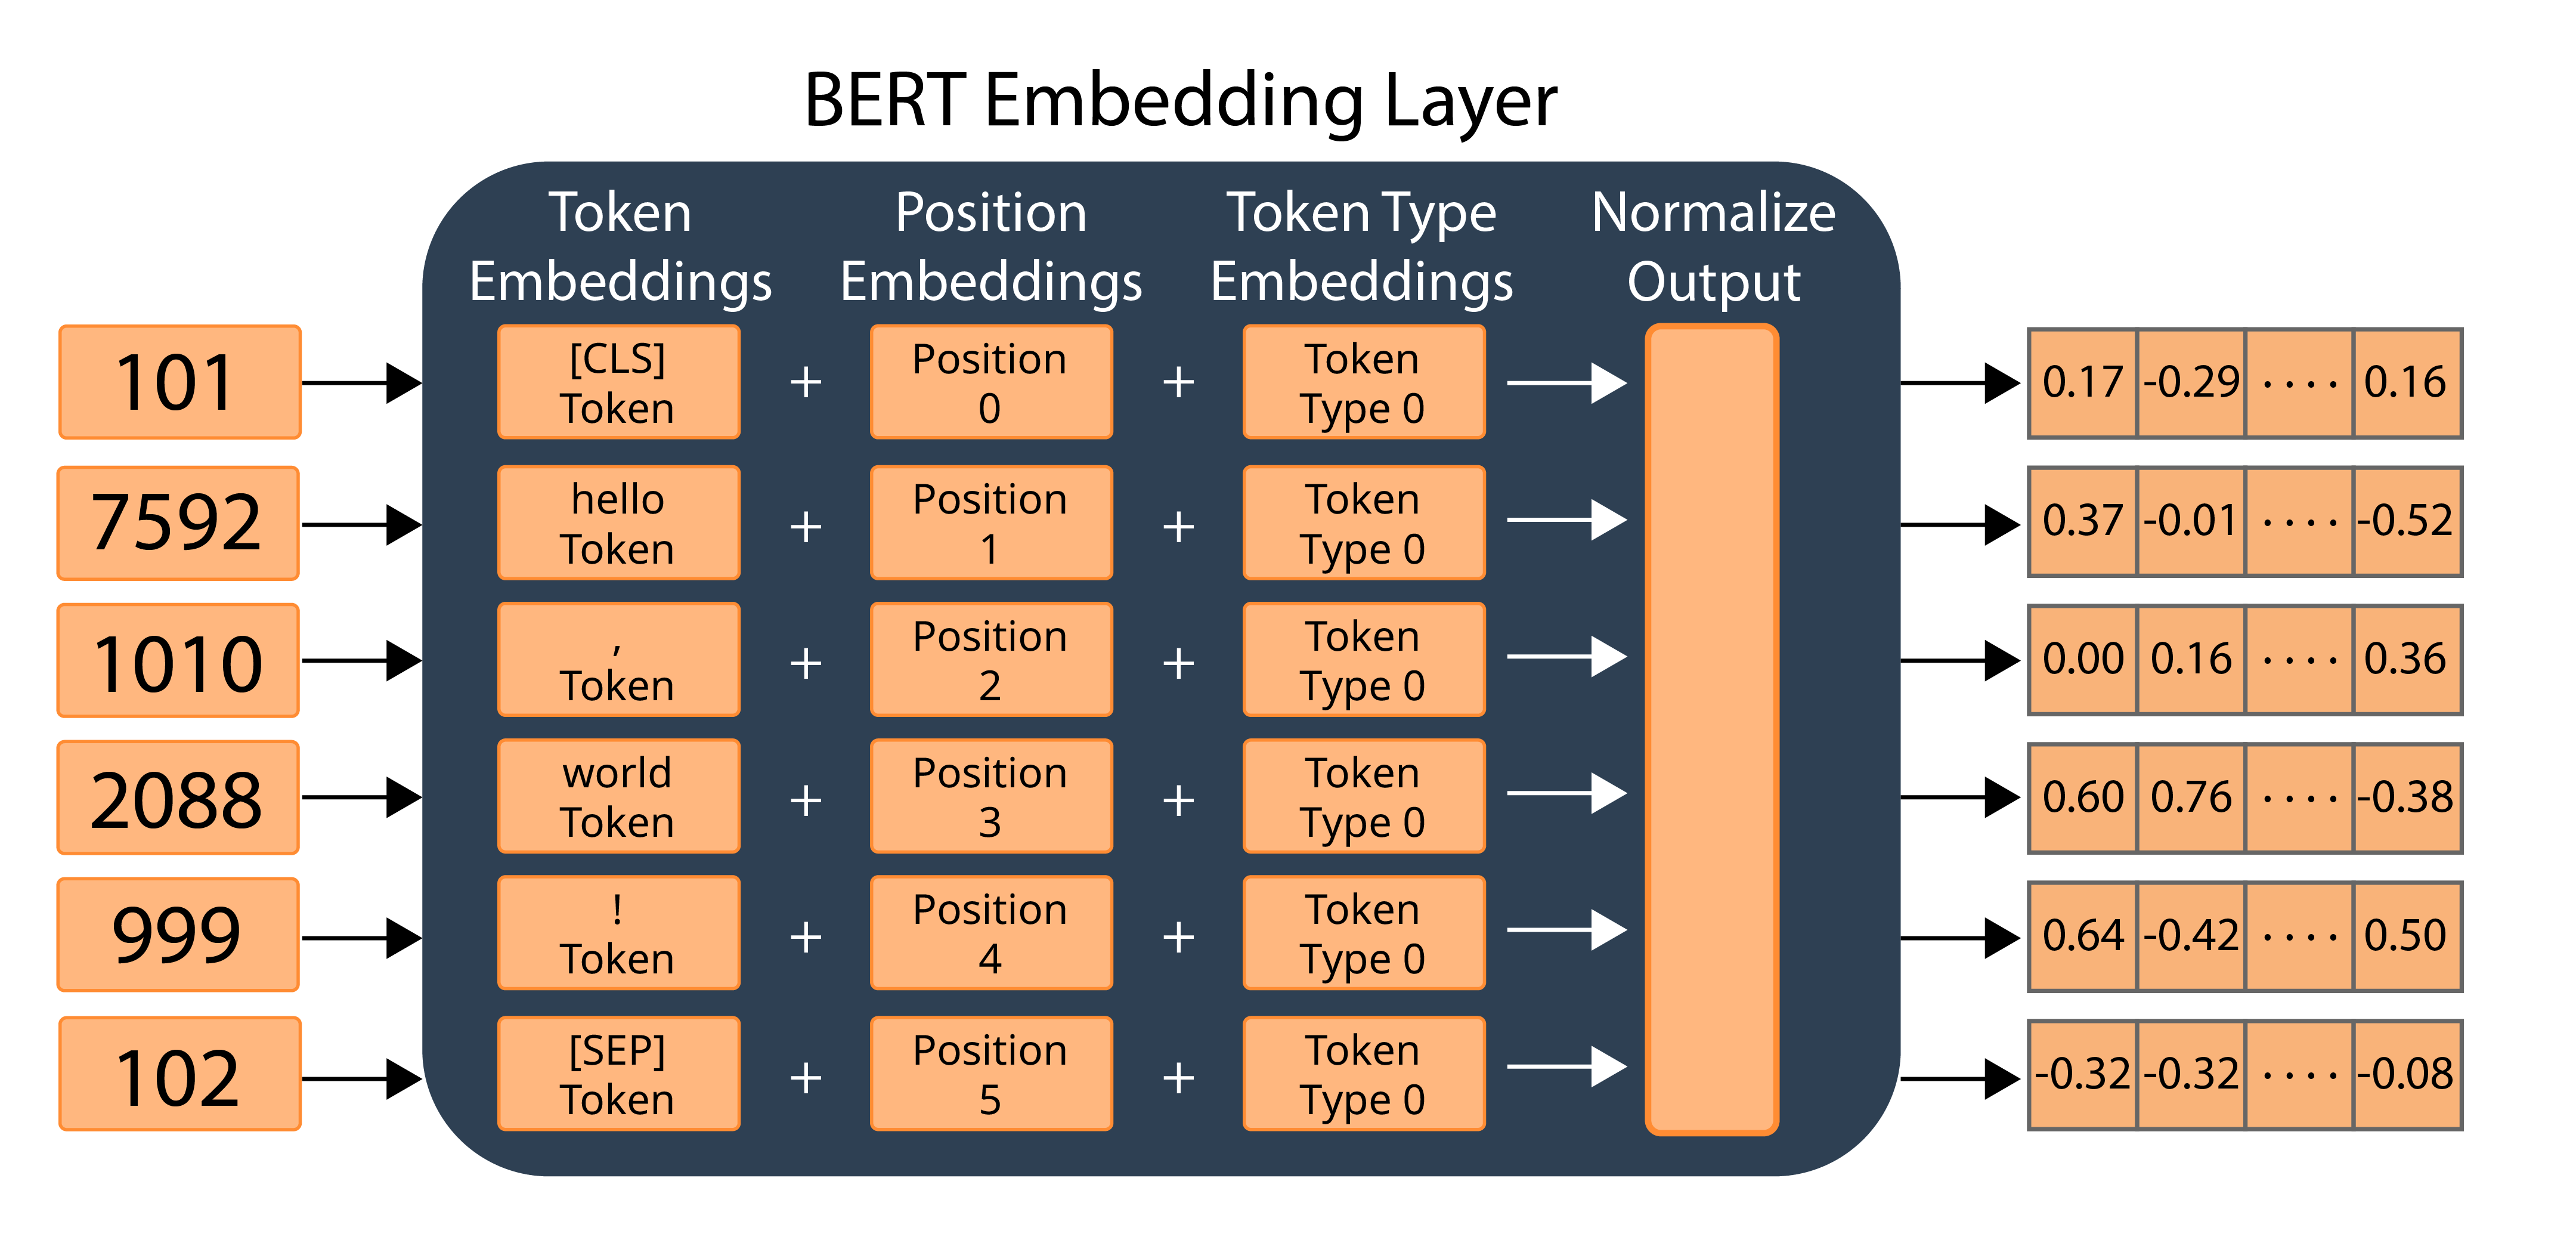

La siguiente función dado una frase, un tokenizador y un modelo, te permite obtener el valor del vector `[CLS]` una vez la frase ha sido procesada por el modelo.

In [ ]:
def document_cls_vector(sentence, tokenizer, model):
  try:
    # Tokenizo
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True,max_length=150,truncation=True)
    # Introduzco los tokens al modelo
    outputs = model(**inputs)
    # Obtengo el valor del CLS token
    cls_token = outputs.last_hidden_state[:, 0, :]
  except:
    print("ERROR")
    print(sentence)
  return cls_token.tolist()[0]



Vamos a aplicar la función con la misma frase que anteriormente.

In [ ]:
vector_representation = document_cls_vector("El gato se tumba en su cama", tokenizer, model)

In [ ]:
vector_representation

Observamos que se obtiene un vector de 768 posiciones (el tamaño dependerá del  modelo utilizado)

In [ ]:
len(vector_representation)

## Comparativa embeddings contextuales y estáticos


De cara a ver como funciona las diferentes representaciones, vamos a utilizar los embeddings estáticos y contextuales para transformar y visualizar los documentos de los subsets de datos `subset_diferente`, que contiene documentos con contenido muy diferente; y `subset_parecido`, que contiene documentos de una temática común pero clasificados por subcategorías.

Esencialmente vamos a:
1. Vectorizar cada uno de los subsets de datos con los dos tipos de embeddings
2. Reducir la dimensionalidad a 2D para poder visualizarlos en una figura.
3. Mostrar resultados en una figura interactiva y comparar resultados.



### Embedding estáticos

Obtenemos la representacion vectorial para las frases de la columna `text_cleaned` utilizando un embedding estático:

In [ ]:
emb_est_diferente = subset_diferente.copy()
emb_est_diferente["vector"] = emb_est_diferente.text_cleaned.progress_apply(lambda x: embedding_doc(x.split(), glove_emb, glove_emb.vector_size))

emb_est_parecido = subset_parecido.copy()
emb_est_parecido["vector"] = emb_est_parecido.text_cleaned.progress_apply(lambda x: embedding_doc(x.split(), glove_emb, glove_emb.vector_size))

In [ ]:
emb_est_parecido.head(1)

Generamos un nuevo dataframe en el que se haya reducido la dimensionalidad del vector a dos dimensiones (X e Y) y además podamos seguir accediendo al nombre de la categoría para facilitar la representación gráfica posterior.

In [ ]:
emb_est_diferente_tsne = tsne_dim_reduction(emb_est_diferente,"vector",42)
emb_est_parecido_tsne = tsne_dim_reduction(emb_est_parecido,"vector",42)

### Embedding contextuales

Para obtener esta representación vectorial de forma rápida deberíamos activar la GPU en Google Colab, si no la obtención de los vectores será bastante lenta:

In [ ]:
emb_con_diferente = subset_diferente.copy()
emb_con_diferente["vector"] = emb_con_diferente.text_cleaned.progress_apply(lambda x: document_cls_vector(x, tokenizer, model))

emb_con_parecido = subset_parecido.copy()
emb_con_parecido["vector"] = emb_con_parecido.text_cleaned.progress_apply(lambda x: document_cls_vector(x, tokenizer, model))

Reducmos la dimensionalidad igual que antes:

In [ ]:
emb_con_diferente_tsne = tsne_dim_reduction(emb_con_diferente,"vector",42)
emb_con_parecido_tsne = tsne_dim_reduction(emb_con_parecido,"vector",42)

### Visualización embedding estático vs embedding contextual

A continuación mostramos en gráficas interactivas los tipos de representación utilizando la función auxiliar `plotly_2_scatters()`. En cada una de las gráficas a la izquierda se visualiza la representación de los documentos utilizando **embeddings estáticos** y a la derecha la representación de los documentos utilizando **embeddings contextuales** (tras la redución de dimensionalidad aplicada previamente).

Cuando mostramos los resultados para los documentos de categorías diferentes ('talk.religion.misc' y 'sci.med') se observa que ambos sistemas de representación son capaces de ubicar en zonas diferentes del espacio los documentos de cada una de las categorías.

- En el caso de los embeddings estáticos (izquierda) existe un solape mayor, lo que indica que, aunque los documentos de 'talk.religion.misc' y 'sci.med' se agrupan en regiones distintas, hay una cantidad significativa de documentos cuya representación vectorial es similar, lo que podría llevar a confusiones al momento de clasificarlos. Esto puede deberse a que los embeddings estáticos generan una única representación para cada palabra, sin tener en cuenta el contexto en el que se usa. Por lo tanto, palabras que se utilizan en contextos diferentes en los dos temas pueden terminar siendo representadas de manera muy similar, lo que contribuye al solape observado.
- En el caso de los embeddings dinámicos (derecha) la separación de los documentos en el espacio vectorial es mucho más clara, evidenciando el poder de este tipo de representación vectorial.

In [ ]:
plotly_2_scatters(emb_est_diferente_tsne, emb_con_diferente_tsne, "target_names", "target_names",  "target_names", width=1400, height=400)

Cuando representamos documentos sobre el mismo tema (política), pero subcategorizados en "mideast", "guns" y "misc" se observa un patrón mucho más marcado.

El embedding estático no es capaz de agrupar en el espacio los documentos con la misma subcategoría, como evidencian los puntos presentes en el espacio sin un patrón común. Sin embargo, el embedding contextual si que es capaz de separar claramente dos de las categorías (mideast vs el resto), e incluso se pueden apreciar patrones de agrupación en los documentos "misc" y "guns".  Esta agrupación de documentos aparece gracias a la representación vectorial de estos documentos, más rica gracias a los mecanismos de atención y al efecto que tiene el contexto en el vector final.


In [ ]:
plotly_2_scatters(emb_est_parecido_tsne, emb_con_parecido_tsne, "target_names", "target_names",  "target_names", width=1400, height=400)